In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pylab as plt
import numpy as np
from squlearn.encoding_circuit import ChebyshevPQC, ChebyshevTower
from squlearn.kernel import ProjectedQuantumKernel
from squlearn.kernel.ml import QKODE

from squlearn.kernel.optimization import KernelOptimizer, ODE_loss
from squlearn.optimizers import Adam, LBFGSB
from squlearn.util import Executor

In [3]:
x_train = np.linspace(0.001, 0.9, 25)
y_train = [np.log(0.001)] #y_initial
feature_map = ChebyshevPQC(num_qubits=4, num_features=1, num_layers=1)
#feature_map = ChebyshevTower(num_qubits=6, num_features=1, num_layers=1, num_chebyshev=4)
q_kernel = ProjectedQuantumKernel(feature_map, Executor())

In [4]:
import sympy as sp

In [5]:
x = sp.symbols('x')
f = sp.Function('f')(x)
dfdx = sp.diff(f, x)

In [6]:
def sympy_loss(sp_ode, x_or_f_arguments):
    def np_loss_out_sp(f_alpha_tensor):
        if len(x_or_f_arguments) <= 3:
            return sp.lambdify(x_or_f_arguments, sp_ode, "numpy")(*f_alpha_tensor[:3])
        return sp.lambdify(x_or_f_arguments, sp_ode, "numpy")(*f_alpha_tensor)
    return np_loss_out_sp

In [7]:
#from DE_Library.diferential_equation_functionals import loss_log_ode
def loss_log_ode(f_alpha_tensor):
    """
    0 = -lamb * np.exp(f * k) + df/dx
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor 

    lamb = 1
    k = 1
    return dfdx - np.exp(-f*k)*lamb 

In [8]:
def ode_loss(vec):
    """
    t = vec[0]
    y(t) = vec[1]

    """
    k = 1
    return [np.exp(vec[1]*k)]

In [9]:
def homogeneous_loss(fun, vec, derivatives_tensor):
    """
    Takes as an input a scipy ode like function and returns the value of the sum of the homogeneous loss given an ansatz and the derivatives tensor
    Args:
        fun: function
        vec: list
        derivatives_tensor: list


    """
    difference_of_derivatives_by_order = [fun(vec)[i] - derivatives_tensor[i] for i in range(len(derivatives_tensor))]
    loss = np.zeros_like(derivatives_tensor[0])
    for i in range(len(derivatives_tensor)):
        loss += difference_of_derivatives_by_order[i]

    return loss 
    

In [10]:
#from DE_Library.diferential_equation_functionals import loss_log_ode
def loss_log_ode(f_alpha_tensor):
    """
    0 = -lamb * np.exp(f * k) + df/dx
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor 

    lamb = 1
    k = 1
    return dfdx - np.exp(-f*k)*lamb 

In [11]:
x = sp.symbols('x')
f = sp.Symbol('f(x)')
k = sp.symbols('k')
dfdx = sp.diff(f, x)
eq = dfdx - sp.exp(-f*1)
l_f = sympy_loss(eq, [x, f, dfdx]) #loss_log_ode

In [12]:
q_kode = QKODE(quantum_kernel=q_kernel, ODE_functional =l_f, optimizer=LBFGSB())

In [13]:
q_kode.fit(x_train, y_train, regularization_parameter = 0.005, initial_parameters_classical=np.random.rand(26))
prediction = q_kode.predict()

TypeError: ODE_loss.__init__() got an unexpected keyword argument 'L_functional'

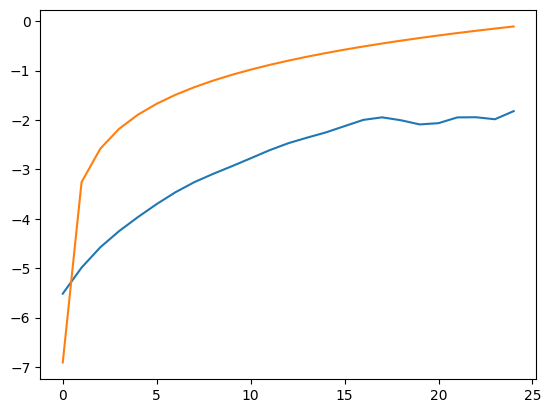

In [ ]:
plt.plot(prediction)
plt.plot(np.log(x_train))